# IFT experiments

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import math
from statistics import mean, stdev
import pandas as pd

import qiskit
from qiskit import *

import pennylane as qml
from pennylane import numpy as pnp

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times']

In [2]:
# float to binary 
def float_to_bin_real(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')
def float_to_bin_imag(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')

# binary to float
def bin_to_float_real(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]
def bin_to_float_imag(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]

# reverse a string (for the measurement step readout)
def reverse(string):
    string = string[::-1]
    return string

In [3]:
def generate_img(n):

    sky_image = np.zeros((n, n), dtype='complex64')
    mask = np.zeros((n, n), dtype='bool')
    stars = np.random.randint(1, 7) 
    radius = 1 

    for i in range(0, stars):
        index_i = np.random.randint(0, n-radius)
        index_j = np.random.randint(0, n-radius)
        for j in range(0, radius):
            for k in range(0, radius):
                sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
                mask[index_i+j][index_j+k] = True
            
    sky_image.real += np.random.randn(n,n)/100
    sky_image.imag += np.random.randn(n,n)/100
    
    visibilities = np.fft.fft2(sky_image).astype('complex64')
    
    return sky_image, visibilities

In [4]:
def binary_encode(qc, binary, off_set):
    
    for i in range(0, len(binary)):
        qc.reset(off_set+i) 

        if binary[i]=='1':
            qc.x(off_set+i) 
    
    off_set += len(binary)

    return off_set

In [5]:
def binary(img):
    
    number_of_pixels = img.shape[0]*img.shape[1]
    number_of_bits_real = 32
    number_of_bits_imag = 32
    number_of_bits = number_of_bits_real + number_of_bits_imag
    number_of_qbits = number_of_pixels*number_of_bits
    off_set = 0

    qc = QuantumCircuit(number_of_qbits)
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
                binary_real = float_to_bin_real(img[i, j].real)
                binary_imag = float_to_bin_imag(img[i, j].imag)
                binary = binary_real+binary_imag
                off_set = binary_encode(qc, binary, off_set)
                
    qc.measure_all()
    backend = Aer.get_backend('aer_simulator') 
    job = backend.run(qc, shots=1, memory=True) 
    output = job.result().get_memory()[0]
    out = reverse(output)
    
    chunks_real = []
    chunks_imag = []
    for i in range(0, number_of_pixels):
        chunks_real.append(out[number_of_bits*i:(number_of_bits*i)+number_of_bits_real]) 
        chunks_imag.append(out[(number_of_bits*i)+number_of_bits_imag:(number_of_bits*i)+number_of_bits_imag+number_of_bits_imag]) 

    readout = []
    for i in range(0, len(chunks_real)):
        readout.append(complex(bin_to_float_real(chunks_real[i]), bin_to_float_imag(chunks_imag[i]))) 

    readout = np.array(readout).reshape(img.shape[0] , img.shape[1]).astype('complex64')
    readout = np.fft.ifft2(readout).astype('complex64') #IFT
    
    return readout

In [6]:
def MSE(img1, img2):
    diff_real = (img1.real - img2.real)
    diff_imag = (img1.imag - img2.imag)
    diff_sum = diff_real + diff_imag
    
    mse = (diff_sum**2).mean()
    
    return mse

In [7]:
img_sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10]
binary_results = []
amplitude_results = []

for i in tqdm(range(0, len(img_sizes))):
    
    iterations = 100
    img_size = img_sizes[i]
    binary_MSE = []
    amplitude_MSE = []

    for j in range(0, iterations):

        initial, visibilities = generate_img(img_size) 

        # BINARY
        binary_readout = binary(visibilities)

        # AMPLITUDE
        n_n = img_size*img_size
        inp = visibilities.flatten()
        norm = qml.math.sum(qml.math.abs(inp) ** 2)
        number_of_qbits = math.ceil(math.log2(n_n))
        wires = range(number_of_qbits)
        amp_dev = qml.device('default.qubit', wires)
        @qml.qnode(amp_dev)
        def amp_encoding(data):
            qml.AmplitudeEmbedding(data, wires, normalize=True, pad_with=0.)
            return qml.state()
        readout = amp_encoding(inp).astype('complex64')
        readout.numpy()
        readout = readout*qml.math.sqrt(norm) 
        readout = readout[:n_n] 
        readout = np.array(readout).reshape(img_size , img_size)
        amplitude_readout = np.fft.ifft2(readout).astype('complex64')

        binary_mse = MSE(initial, binary_readout)
        amplitude_mse = MSE(initial, amplitude_readout)

        binary_MSE.append(binary_mse)
        amplitude_MSE.append(amplitude_mse)

    binary_mean = mean(binary_MSE)
    binary_std = np.std(binary_MSE)
    amplitude_mean = mean(amplitude_MSE)
    amplitude_std = np.std(amplitude_MSE)
    
    binary_results.append((binary_mean, binary_std))
    amplitude_results.append((amplitude_mean, amplitude_std))

print('Binary results: '+ '\033[1m' + str(binary_results) + '\033[0m')
print()
print('Amplitude results: '+ '\033[1m' + str(amplitude_results) + '\033[0m')

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [19:25<00:00, 129.55s/it]

Binary results: [(7.4071305e-13, 9.318306e-13), (8.231957e-13, 7.0513517e-13), (6.184526e-13, 5.1074997e-13), (4.5845657e-13, 3.1678935e-13), (3.7541937e-13, 2.691695e-13), (2.8956012e-13, 1.9036347e-13), (2.1908499e-13, 1.4241265e-13), (1.6243966e-13, 8.473964e-14), (1.5101828e-13, 9.1092674e-14)]

Amplitude results: [(4.505465e-12, 9.979801e-12), (7.559815e-12, 1.3129001e-11), (3.2380164e-12, 4.543424e-12), (2.7083034e-12, 4.0453205e-12), (3.2974413e-12, 4.0501955e-12), (2.2260022e-12, 2.9366544e-12), (9.871538e-13, 1.4415105e-12), (1.0470022e-12, 1.6801641e-12), (1.0763986e-12, 1.5058522e-12)]


In [8]:
binary_tmp = []
for i in range(0, len(binary_results)):
    binary_tmp.append(binary_results[i][0])
binary_absolute_mean = mean(binary_tmp)

amplitude_tmp = []
for i in range(0, len(amplitude_results)):
    amplitude_tmp.append(amplitude_results[i][0])
amplitude_absolute_mean = mean(amplitude_tmp)

binary_tmp2 = []
for i in range(0, len(binary_results)):
    binary_tmp2.append(binary_results[i][1])
binary_absolute_std = mean(binary_tmp2)

amplitude_tmp2 = []
for i in range(0, len(amplitude_results)):
    amplitude_tmp2.append(amplitude_results[i][1])
amplitude_absolute_std = mean(amplitude_tmp2)

print('Binary absolute mean: '+ '\033[1m' + str(binary_absolute_mean) + '\033[0m')
print('Binary absolute std: '+ '\033[1m' + str(binary_absolute_std) + '\033[0m')
print()
print('Amplitude absolute mean: '+ '\033[1m' + str(amplitude_absolute_mean) + '\033[0m')
print('Amplitude absolute std: '+ '\033[1m' + str(amplitude_absolute_std) + '\033[0m')

Binary absolute mean: 4.2648225e-13
Binary absolute std: 3.6025366e-13

Amplitude absolute mean: 2.960622e-12
Amplitude absolute std: 4.812436e-12


In [9]:
df_mean = pd.DataFrame({'antennas':['2','3','4','5','6','7','8','9','10'],
                   'Binary':binary_tmp,
                    'Amplitude':amplitude_tmp})
df_mean = df_mean.set_index('antennas')
df_mean

,Binary,Amplitude
antennas,,
2,7.407130e-13,4.505465e-12
3,8.231957e-13,7.559815e-12
4,6.184526e-13,3.238016e-12
5,4.584566e-13,2.708303e-12
6,3.754194e-13,3.297441e-12
7,2.895601e-13,2.226002e-12
8,2.190850e-13,9.871538e-13
9,1.624397e-13,1.047002e-12
10,1.510183e-13,1.076399e-12


In [10]:
df_std = pd.DataFrame({'antennas':['2','3','4','5','6','7','8','9','10'],
                   'Binary':binary_tmp2,
                    'Amplitude':amplitude_tmp2})
df_std = df_std.set_index('antennas')
df_std

,Binary,Amplitude
antennas,,
2,9.318306e-13,9.979801e-12
3,7.051352e-13,1.312900e-11
4,5.107500e-13,4.543424e-12
5,3.167893e-13,4.045321e-12
6,2.691695e-13,4.050196e-12
7,1.903635e-13,2.936654e-12
8,1.424127e-13,1.441511e-12
9,8.473964e-14,1.680164e-12
10,9.109267e-14,1.505852e-12


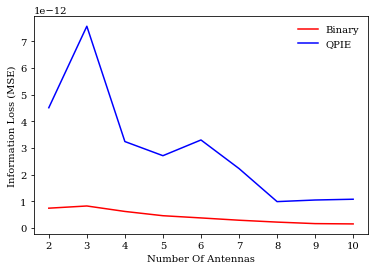

In [14]:
x = img_sizes
plt.plot(x, binary_tmp, label = "Binary", color='red')
plt.plot(x, amplitude_tmp, label = "QPIE", color='blue')
plt.xlabel('Number Of Antennas')
plt.ylabel('Information Loss (MSE)')
plt.legend(loc=0, frameon=False)

plt.savefig('plot1.pdf')
plt.show()

In [15]:
binary_qubits = [256,576,1024,1600,2304,3136,4096,5184,6400]
binary_qubits_mean = mean(binary_qubits)
amplitude_qubits = [2,4,4,5,6,6,6,7,7]
amplitude_qubits_mean = mean(amplitude_qubits)
print(binary_qubits_mean)
print()
print(amplitude_qubits_mean)

2730.6666666666665

5.222222222222222


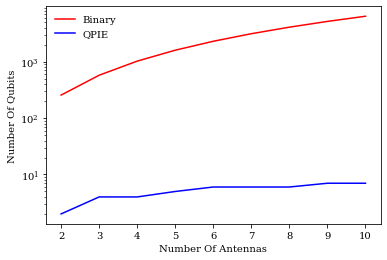

In [16]:
x = img_sizes
plt.plot(x, binary_qubits, label = "Binary", color='red')
plt.plot(x, amplitude_qubits, label = "QPIE", color='blue')
plt.xlabel('Number Of Antennas')
plt.ylabel('Number Of Qubits')
plt.legend(loc=0, frameon=False)
plt.yscale("log")  
plt.savefig('plot2.pdf')
plt.show()